In [1]:
import numpy as np
from tqdm.notebook import tqdm
from keras.datasets import mnist
from tensorflow.keras import Model
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, LeakyReLU, Flatten, Dropout, MaxPooling2D
# any additional imports you may require


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# **Loading Dataset**

You will be using MNIST handwritten digits to create a digit detection system. The dataset contain binary images of handwritten digits, and has has a training set of 60,000 examples, and a test set of 10,000 examples. The dataset can be loaded using the following commands:

> from keras.datasets import mnist

> (trainX, trainY), (testX, testY) = mnist.load_data()

Starter code has already been provided to you. In the load_dataset() function, perform the following tasks:


*   Normalize pixel values between 0 and 1
*   One hot encode true labels using the [to_categorical()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) function.



In [2]:
def load_dataset():
  # loading dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
  
  ############## Write your code here ###################
    testY2 = testY
    trainY2 = trainY
    trainX = trainX/255
    testX = testX/255
    
    trainY = to_categorical(trainY, num_classes=10)
    testY = to_categorical(testY, num_classes=10)
     
  #######################################################
    return trainX, trainY, testX, testY, trainY2, testY2

In [3]:
trainX, trainY, testX, testY, trainY2, testY2 = load_dataset()

# **Part 1**

In the first part, you will be creating a neural network from scratch.  Often the code ishidden behind libraries.  The purpose of this task is to give you hand-on experience withthe mathematical foundations of neural network architectures.  After implementing this task, you will know exactly how forward and backward pass functions are implemented mathematically and in code. 

In [32]:
class NeuralNetwork():
  
  @staticmethod
  def cross_entropy_loss(y_pred, y_true):
    loss = None
    ############## Write your code here ###################
    index = np.where(y_true == 1)
    loss = -1 * np.log(y_pred[index]) 
    #######################################################
    return loss

  @staticmethod
  def softmax(Z):
    '''Used as the activation function in output layer'''

    output = None
    ############## Write your code here ###################
    temp = np.exp(Z)
    output = temp / np.sum(temp)
    #######################################################
    return output

  @staticmethod
  def sigmoid(Z):
    '''Used as the activation function in every hidden layer'''
    
    output = None
    ############## Write your code here ###################
    output = 1/(1+np.exp(-1*Z))
    #######################################################
    return output


  def __init__(self, list_of_nodes):
    '''Constructor of our neural network class'''
    
    if len(list_of_nodes) < 2:
        raise ValueError('Network must have atleast 2 layers (input and output).')
    if not (np.array(list_of_nodes) > 0).all():
        raise ValueError('Number of nodes in all layers must be positive.')
    
    self.total_layers = None # total layers of your neural network
    self.list_of_nodes = None # list containing count of the number of nodes in every layer.
    self.input_shape = None # number of nodes in input layer
    self.output_shape = None # number of nodes in output layer
    ############## Write your code here ###################
    self.total_layers = len(list_of_nodes)
    self.list_of_nodes = list_of_nodes
    self.input_shape = self.list_of_nodes[0]
    self.output_shape = self.list_of_nodes[-1]
    #######################################################

    self.__init_weights_and_biases(list_of_nodes)

  def __init_weights_and_biases(self, list_of_nodes):
    '''Initialize all weights based on normal standard distribution and all biases to 0'''

    self.weights_ = []
    self.biases_ = []
    for i,_ in enumerate(list_of_nodes):
        if i == 0:
            #Input layer is skipped because it has no weights or biases
            continue
        
        Weights = None
        Biases = None
        ############## Write your code here ###################
        Weights = np.random.normal(size=(list_of_nodes[i], list_of_nodes[i-1]))
        Biases = np.zeros((list_of_nodes[i],1))
        #######################################################
        
        self.weights_.append(Weights)
        self.biases_.append(Biases)

  def forward_pass(self, input_data):
    '''
    Traverse the neural network and calculate the output of every layer.
    The function should return a list containing outputs of every layer.
    '''
    layer_outputs = []
    layer_outputs.append(input_data.transpose())
    ############## Write your code here ###################
    for i in range(self.total_layers - 1):
      layer_computation = np.matmul(self.weights_[i], layer_outputs[i]) + self.biases_[i]
      if (i == self.total_layers - 2):
        layer_computation = self.softmax(layer_computation)
      else:
        layer_computation = self.sigmoid(layer_computation)
      layer_outputs.append(layer_computation)
    #######################################################
    return layer_outputs

  def backward_pass(self,y, layer_outputs):
    '''
    Traverse the neural network starting from the output layer. 
    and compute partial derivatives. 
    The function should return a list containing partial derivatives of every layer.
    '''
    derivatives = []
    ############## Write your code here ###################
    # starting from last layer, then move back iteratively

    # for first layer, it is just diff of actual label and predicted labels
    predicted_probs = layer_outputs[-1].transpose()
    # using derivative of cross entropy loss
    delta = np.subtract(predicted_probs, y)
#     delta = -np.subtract(np.divide(y,predicted_probs),np.divide(1-y,1-predicted_probs))
#     delta = -1 * np.subtract((np.divide(y, predicted_probs), np.divide((1-y)/(1-predicted_probs))))
    derivatives.append(delta)

    for i in range(len(layer_outputs) - 2):
      current_nodes = layer_outputs[-2-i].transpose()
      current_weights = self.weights_[-1-i]
      deriv_activation = np.multiply(current_nodes, 1-current_nodes) # because we are using sigmoid => z' * (1 - z')
      loss = np.matmul(derivatives[0], current_weights) # W[L+1] * delta (L/z(l+1))
      delta = np.multiply(deriv_activation, loss) # element wise multiplication! not matrix
      derivatives.insert(0, delta)

    #######################################################
    return derivatives

  def update(self, derivatives, layer_outputs,learning_rate):
    '''Update weights and biases'''

    ############## Write your code here ###################
    for i in range(len(self.weights_)):
      self.weights_[i] = self.weights_[i] - learning_rate * (np.matmul(layer_outputs[i], derivatives[i])).transpose()
      self.biases_[i] = self.biases_[i] - learning_rate * derivatives[i].sum()
    #######################################################

  def fit(self, X_train, Y_train, epochs, learning_rate):
    ''' Call forward_pass(), backward_pass(), and the update() function'''

    training_loss = []
    validation_loss = []
    training_accuracy = []
    validation_accuracy = []
    
    #dividing training data into training set and validation set
    X_train_set = X_train[6000:]
    Y_train_set = Y_train[6000:]
    X_valid_set = X_train[0:6000]
    Y_valid_set = Y_train[0:6000]

    for epoch in tqdm(range(epochs)):

      #Stochastic gradient descent
      num_samples = X_train_set.shape[0]
      for i in range(num_samples):
        
        x = X_train_set[i,:].reshape((1,self.input_shape)) # features of the ith sample
        y = Y_train_set[i,:].reshape((1,self.output_shape)) # true label of the ith sample
        
        layer_outputs = None
        derivatives = None

        ############## Write your code here ###################
        node_outputs = self.forward_pass(x)
        deltas = self.backward_pass(y, node_outputs)
        self.update(deltas, node_outputs, learning_rate)
        #######################################################
      # moving all of this inside the for loop so that we can get data for a large number of indices
        
      train_predict = self.predict(X_train_set)
      validation_predict = self.predict(X_valid_set)

      training_loss.append(self.cross_entropy_loss(train_predict, Y_train_set)) #appending training loss
      validation_loss.append(self.cross_entropy_loss(validation_predict, Y_valid_set)) #appending validation loss
      training_accuracy.append(accuracy_score(np.argmax(Y_train_set,axis=1),np.argmax(train_predict,axis=1))) # appending training accuracy
      validation_accuracy.append(accuracy_score(np.argmax(Y_valid_set,axis=1),np.argmax(validation_predict,axis=1))) # appending validation accuracy
    return training_loss, validation_loss, training_accuracy, validation_accuracy

  def evaluate(self,Y_true,Y_pred):
    '''
    Calculate classification accuracy, F1 score and confusion matrix
    '''
    ############## Write your code here ###################
    num_classes = 10
    confusion_matrix = np.zeros(shape=(num_classes, num_classes))
    for i in range(len(Y_true)):
      confusion_matrix[Y_pred[i]][Y_true[i]] += 1
    accuracy = 0
    for i in range(num_classes):
      accuracy += confusion_matrix[i][i]
    accuracy = accuracy / len(Y_true)
    print(confusion_matrix)
    recall_vec = []
    precision_vec = []
    for i in range(num_classes):
      try:
        recall = confusion_matrix[i,i]/np.sum(confusion_matrix[:,i])
      except:
        recall = 0
      recall_vec.append(recall)
      try: 
        precision = confusion_matrix[i,i]/np.sum(confusion_matrix[i])
      except:
        precision = 0
      precision_vec.append(precision)

    macro_avg_precision = precision_vec.sum() / num_classes
    macro_avg_recall = recall_vec.sum() / num_classes
    f1_score = 2*macro_avg_recall*macro_avg_precision/(macro_avg_recall+macro_avg_precision)
    #######################################################
    
    return accuracy, confusion_matrix, f1_score

  def predict(self, X):
    predicted_labels = []
    n = X.shape[0]
    for i in range(n):
        x = X[i,:].reshape((1,self.input_shape))
        y_pred = self.forward_pass(x)[-1]
        predicted_labels.append(y_pred.reshape((self.output_shape,)))
    return np.array(predicted_labels)

Reshape the dataset to a 2D array using [NumPy reshape function](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).

In [10]:
############## Write your code here ###################
train_points_count = trainX.shape[0]
test_points_count = testX.shape[0]
num_features = trainX.shape[1] * trainX.shape[2]

trainX = np.reshape(trainX, (train_points_count, num_features))
testX = np.reshape(testX, (test_points_count, num_features))
#######################################################
print('Train: X=%s, Y=%s' % (trainX.shape, trainY.shape)) #should print "Train: X=(60000, 784), y=(60000,10)"
print('Test: X=%s, Y=%s' % (testX.shape, testY.shape)) #should print "Test: X=(10000, 784), y=(10000,10)"

IndexError: tuple index out of range

Initialize your class. The class can have arbitrary number of hidden layers and nodes depending on the parameters passed. For example, the class instance declared as:


> **nn = NeuralNetwork([784,20,20,10])**


contains an input layer with 784 nodes, 2 hidden layer with 20 nodes each and an output layer with 10 nodes.

In [33]:
nn = None
############## Write your code here ###################
nn = NeuralNetwork([784, 20, 20, 10])
#######################################################

Call the fit function to train your model.

In [13]:
training_loss = None
validation_loss = None
training_accuracy = None
validation_accuracy = None
epochs = 40
learning_rate = 0.01
############## Write your code here ###################
training_loss, validation_loss, training_accuracy, validation_accuracy = nn.fit(trainX, trainY, epochs, learning_rate)
#######################################################

  0%|          | 0/10 [00:00<?, ?it/s]

In [37]:
predictions_ = nn.predict(testX)
predictions = np.argmax(predictions_, axis=1)
accuracy, con_mat = nn.evaluate(testY2, predictions)
print(accuracy)
# print(f1_score)

[[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [5.000e+00 1.520e+02 2.000e+00 2.100e+01 5.000e+00 1.100e+01 1.000e+00
  5.000e+00 0.000e+00 2.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [3.000e+00 3.700e+01 4.000e+00 2.700e+01 1.700e+01 7.000e+00 2.000e+00
  5.200e+01 2.000e+00 4.800e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [9.710e+02 9.460e+02 1.026e+03 9.620e+02 9.600e+02 8.730e+02 9.550e+02
  9.710e+02 9.720e+02 9.590e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.0

In [ ]:
training_loss_vec = validation_loss_vec = training_accuracy_vec = validation_accuracy_vec = []
for i in tqdm(range(8)):
    nn = NeuralNetwork([784, 20, 20, 10])
    epochs = (i+1)*10
    learning_rate = 0.01
    training_loss, validation_loss, training_accuracy, validation_accuracy = nn.fit(trainX, trainY, epochs, learning_rate)
    training_loss_vec.append(training_loss)
    validation_loss_vec.append(validation_loss)
    training_accuracy_vec.append(training_accuracy)
    validation_accuracy_vec.append(validation_accuracy)

training_loss_vec_0 = validation_loss_vec_0 = training_accuracy_vec_0 = validation_accuracy_vec_0 = []
for i in tqdm(range(8)):
    nn = NeuralNetwork([784, 20, 20, 10])
    epochs = (i+1)*10
    learning_rate = 0.001
    training_loss, validation_loss, training_accuracy, validation_accuracy = nn.fit(trainX, trainY, epochs, learning_rate)
    training_loss_vec_0.append(training_loss)
    validation_loss_vec_0.append(validation_loss)
    training_accuracy_vec_0.append(training_accuracy)
    validation_accuracy_vec_0.append(validation_accuracy)


Plot graphs for different types of neural network architectures. Also experiment with different learning rates. No of epochs should be on the $x$-axis and training \& validation loss on the $y$-axis.

In [78]:
############## Write your code here ###################

#######################################################

Predict the labels of test data using the *predict() function*. Skeleton code for this function is already given to you. You may find [np.argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) useful to extract labels.

In [ ]:
############## Write your code here ###################

#######################################################

Implement and call the evaluate function. Pass true labels and predicted labels of test data as parameters and report your results.

In [ ]:
############## Write your code here ###################

#######################################################

# **Part 2**

In this part, you will get hands-on experience in using tensorflow libraries to implement a CNN for the same mnist dataset used in part 1. It will also give you an idea which model performs better. For this part it is recommended to use Google Colab and GPU for faster training.

For this part, you will need to reshape both testX and trainX. We want the shape of trainX to be (60000,28,28,1) and the shape of testX to be (10000,28,28,1). Use np.reshape for this.

In [6]:
#reshape here
trainX = trainX.reshape((60000,28,28,1))
testX = testX.reshape((10000,28,28,1))

In [7]:
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape)) #should print "Train: X=(60000,28,28,1), y=(60000,10)"
print('Test: X=%s, y=%s' % (testX.shape, testY.shape)) #should print "Test: X=(10000,28,28,1), y=(10000,10)"

Train: X=(60000, 28, 28, 1), y=(60000, 10)
Test: X=(10000, 28, 28, 1), y=(10000, 10)


In [8]:
#Do not change this, it will be used in the end
labels={}
labels['0'] = 0
labels['1'] = 1
labels['2'] = 2
labels['3'] = 3
labels['4'] = 4
labels['5'] = 5
labels['6'] = 6
labels['7'] = 7
labels['8'] = 8
labels['9'] = 9

In [9]:
#Hyperparameters, you can change them accordingly to get higher accuracy on test dataset
input_shape = (28,28,1)
learning_rate = None
batch_size = None
epochs = None

# Training

Build model here. Use Functional API of tensorflow to this. You can have a look [here](https://www.tensorflow.org/guide/keras/functional) to understand how this works.
Model architecture:
*   See the image below for model architecture 
*   For convolutional layer, use kernel size as (3,3) and use relu as activation function
*   For Max Pooling layer, use pool size = (2,2)
*   Last Layer has softmax activation, the second last layer has relu activation
*   Total number of parameters should be 542,230







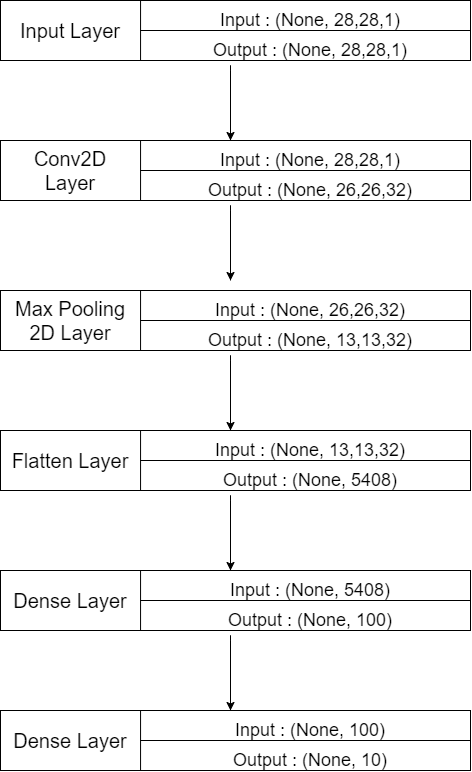

In [ ]:
def define_model():
  #use tensorflow layers to create model
  return model

In [ ]:
#create model here and print summary

Compile model here by using optimizer = Adam, loss = categorical_crossentropy and metrics = accuracy. Use model.compile() for this. See [this](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) documentation. For seeing how to use optimizer, see [this](https://keras.io/api/optimizers/) link.

In [ ]:
#compile model here

Fit your model here. Use model.fit().  See [this](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation to understand model.fit(). Pass in argument steps_per_epoch = floor(Total_train_images/batch_size) 

In [ ]:
#fit your model here

Plot the loss and accuracy graphs of training. Use hist.history['loss'] and hist.history['accuracy'] where hist is returned by model.fit()

In [ ]:
#Plot Loss

In [ ]:
#Plot Accuracy

# Testing

Make predictions on Test Data. Use model.predict() for this

In [ ]:
#make predictions here

Extract class label from the predictions. You may find np.argmax() useful for this

In [ ]:
#code here

Calculate and print accuracy on test data.

In [ ]:
#code here

Plot the confusion matrix here using the sklearn library. Have a look [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for this.

In [ ]:
#code here

In [ ]:
def plot_confusion_matrix(conf_mat):
    classes = list(labels.keys())
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.1)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 10})
    plt.show()

Use the above function for plotting confusion matrix.

In [ ]:
#code here